# Load and initialize


settings


In [1]:
# sample number

j = 'b234_adj'
group_ind = 2
dir_data1 = 'Data_working_version'

args = {
        # create visualization (umap, dbscan are always shown)
        'visualize':True,'plotUMAP' : True,
        # show figures in notebook
        'show' : True, 'saveSVG' :False,
        # calculate umap
        'calc_umap' : False
        }
create_adjusted = False

envirement


In [2]:

from tqdm import tqdm_notebook, tqdm
import datetime

import pandas as pd
from matplotlib.pyplot import rc_context
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
import sys
import pathlib
import os
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
import time
start = time.process_time()
date = datetime.date.today().strftime("%d%m%Y")
# import time

# import matplotlib

plt.rcParams["figure.figsize"] = (5.0, 4.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 180)  # according to screen width
# from pandas.core.base import PandasObject
# PandasObject.view = view #allows view meth pd.view

# from scipy import signal, stats
# import seaborn as sns

# from sklearn import metrics

# from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
# from sklearn.metrics import silhouette_samples,silhouette_score
# from sklearn.neighbors import kneighbors_graph

# from lmfit import minimize, Parameters


parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir+'/functions/')

# from epinuc import *
from usefull_functions import *
from functions import *
from plot_functions import *
from clustering_functions import *
from xg_shap import *    


%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%autoreload 2


# TF_ENABLE_ONEDNN_OPTS=0


/home/yishai/anaconda3/envs/torch39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load data; normalized (CD45-)


In [3]:
j, group_ind, dir_data1,args = getJ(j, group_ind, dir_data1,args)



dir_data = os.path.abspath(os.path.join(    parent_dir, os.pardir))+f'/{dir_data1}/'
dir_plots = os.path.abspath(os.path.join(
    parent_dir, os.pardir))+f'/_sample_{j}_{dir_data1}_{date}/'
folderExists(dir_plots)
settings = (dir_plots, args['show'], args['saveSVG'])

if 'b' not in j:
    singleSample = True
else:
    singleSample = False
print(f'singleSample is: {singleSample}')

# k_orig = pickle_load('k'+j+'_dict',dir_data )['k']
# k = k_orig.copy()
# CAll=pd.concat([k]).copy()

k = pickle_load('k'+j+'_dict', dir_data)['k']
CAll = pd.concat([k.copy()])
print(len(k))


names_dict = pickle_load('k'+j+'_names_dict', dir_data)
NamesAll = names_dict['NamesAll']
CellIden = names_dict['CellIden']
EpiCols = names_dict['EpiCols']
Core = names_dict['Core']
CellIden_EpiCols = CellIden + EpiCols

# dict = None

groups = [['CellIden', 'EpiCols', 'CellIden+EpiCols',],
          [CellIden, EpiCols, CellIden_EpiCols]]

names = [[f'samp{j}_CellIden_', f'samp{j} CellIden Based'],
         [f'samp{j}_EpiCols_', f'samp{j} EpiCols Based'],
         [f'samp{j}_CellIden+EpiCols_', f'samp{j} CellIden+EpiCols Based'],
         ]

params = ['iden', 'epi', 'all',]

if j =='14.2_adj' and group_ind==3:
    groups[0].append( 'CellCycle')   
    groups[1].append( ['CyclinB1', 'pRB','H3S28p'] )   
    names.append(   [f'samp{j}_CellCycle_', f'samp{j} CellCycle Based'])
    params.append('cell')

current j = b234_adj,group_ind = 2, add = Data
singleSample is: False
kb234_adj_dict ; loaded from file
45802
kb234_adj_names_dict ; loaded from file


Visualize data

no point to print data.describe() as it is whitened (std~1, mean~0)


In [4]:
# if show:

#     for features in [NamesAll,Core,CellIden,EpiCols,CellIden_EpiCols]:
#         print(len(features))
#         print(features)


# Cell Identity


In [5]:

figname, title = names[group_ind]
name, featureGroup = groups[0][group_ind], groups[1][group_ind]
print(name, title, figname)


CellIden+EpiCols sampb234_adj CellIden+EpiCols Based sampb234_adj_CellIden+EpiCols_


### UMAP

plot for each feature according to its intensity


min_dist:0.1, n_neighbors:10
umapData_sampb234_adj_CellIden+EpiCols_ ; loaded from file


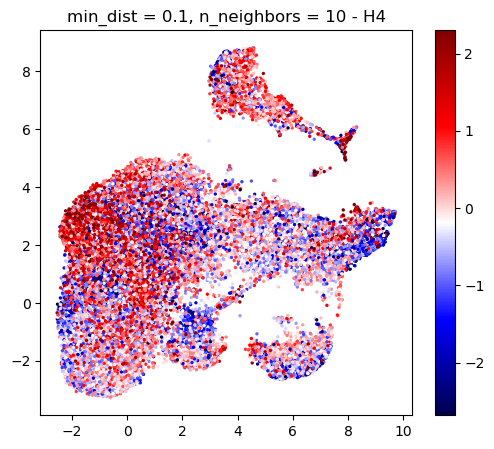

In [6]:

min_dist, n_neighbors = getValsCsv(    dir_data, vars=[params[group_ind], 'umap', j])
# min_dist, n_neighbors = 0.02,10
print(f'min_dist:{min_dist}, n_neighbors:{n_neighbors}')
# calc_umap = True
if args['calc_umap']:
    umapData = calculate_umap(CAll[featureGroup].copy(), n_neighbors, min_dist)
    pickle_dump(f'umapData_{figname}', umapData, dir_data)
else:
    umapData = pickle_load(f'umapData_{figname}', dir_data)
drawUMAP(umapData, ['H4'], CAll, settings,
         title=f'min_dist = {min_dist}, n_neighbors = {n_neighbors}',
         Figname='1_'+figname+'UMAP_(core)')


### Dbscan and clusters


Dbscan


0.1, 200
Estimated number of clusters: 11
Estimated number of noise points: 7138
Silhouette Coefficient: 0.231


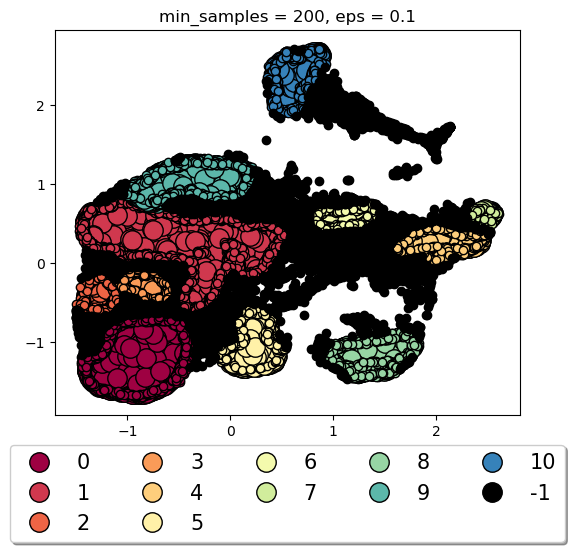

In [7]:
eps, min_samples = getValsCsv(dir_data, vars=[params[group_ind], 'db', j])
# eps,min_samples = 0.1,240
print(f'{eps}, {min_samples}')

dbscanData, labels, core_samples_mask  = calculate_dbscan(umapData,list(k.index), eps, min_samples)
colors = drawDbscan(dbscanData, labels, core_samples_mask, settings,
                    title=f'min_samples = {min_samples}, eps = {eps}',
                    figname='1_'+figname+'dbscan')
k['Clust'] = labels
pickle_dump(f'dbLabels_{figname}', labels, dir_data);pickle_dump(f'dbColors_{figname}', colors, dir_data)


adjusted dataset


In [8]:
# def load_adjusted(j,k,dir_indexes):
#     # k = k[j].copy()
#     Ind, by_sample= pickle_load(f"{j}_adjusted_subsample_indexes",dir_indexes)
#     uniq = [int(i) if i != 4.1 else float(i)  for i in np.unique(by_sample)]
#     # appendDict ={}
    
#     k_append= pd.DataFrame()
#     for samp in uniq:
#         K=k[k['by_sample']==samp].copy()
#         samp_idx = Ind[by_sample ==samp]
        
#         kInd = [True if (i in samp_idx) else False for i in np.asarray(K.Ind)]
#         K = K[kInd]
#         k_append = pd.concat([k_append,K.copy()], ignore_index=True,axis=0,)
#     return k_append
if (j == 'b234' or j == '14.2') and group_ind==2 and create_adjusted:
    dir_indexes =  '/home/yishai/breast_cancer/indexes/'


    clusters = [4, 3]  # clusters to remove
    ind = ~np.zeros_like(labels).astype(bool)
    for cluster in clusters:
        ind *= ~(labels == cluster)
    idx = np.asarray([i for i, j in enumerate(ind) if j])
    newK = k.loc[idx].copy().reset_index(drop = True)

    pickle_dump(f"{j}_adjusted_indexes", idx,dir_indexes)

    dict = None;dict ={}
    dict['k'] = newK.copy()
    pickle_dump(f'k{j}_adj_dict', dict,dir_data)
    pickle_dump(f'k{j}_adj_names_dict', names_dict,dir_data)
    print (f'k{j}; samples = ', len(newK), ', fetures = ', len(newK.columns),'; saved to file')


    colors = drawDbscan(dbscanData[idx], labels[idx], core_samples_mask[idx], settings,
                        title=f'min_samples = {min_samples}, eps = {eps}',
                        figname='1_'+figname+'dbscan_adjusted')
    # plotClusters(newK, umapData[ind], labels[ind], colors, NamesAll, settings,
    #              title='Clusters ' + title,
    #              figname='1_'+figname+'Clusters_adjusted')


clusters

### HeatMap by clusters


In [9]:
from plot_functions import *

if args['visualize']:
    
    for group_name, group in zip(groups[0], groups[1]):
        
        HeatMap(k[labels != -1], group, settings,clustFeature='Clust',
                title='HeatMap ' + title + ': '+group_name,
                figname='1_'+figname+'ClustHeatMap_by_'+group_name)
    


The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


specific clusters and features

In [10]:
# from plot_functions import *
# if args['visualize']:
#     clusters =[0,1]
#     group_name, group = 'specific_markers', ['H3K9me2', 'H3K4me3','H3K36me3','H4K20me3']
#     kk=k.copy()
#     # -----------------
#     k = k.loc[[True if c in clusters else False for c in k['Clust'] ]]
#     HeatMap(k, group, settings,clustFeature='Clust',
#     title='HeatMap ' + title + ': '+group_name,
#                 figname='1_'+figname+'ClustHeatMap_by_'+group_name)
#     # ---------------------
#     k=kk.copy()
#     kk = None



### HeatMap by sample


In [11]:
if args['visualize'] and not singleSample:
    group_name, group = groups[0][-1], groups[1][-1]
    HeatMap(k[labels != -1], group, settings, clustFeature='by_sample',
            title='HeatMap ' + title + ': ' + group_name+' by_sample',
            figname='1_'+figname+'SampHeatMap_'+group_name)


The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


### MeanDist


In [12]:

if args['visualize']:
    for group_name, group in zip(groups[0], groups[1]):
        MeanDist(k[labels == 0], k[labels == 1], group, settings,
                title='MeanDist ' + title + ': '+group_name,
                figname='1_'+figname+'ClustMeanDist_by_'+group_name)


## sample percentage


by sample

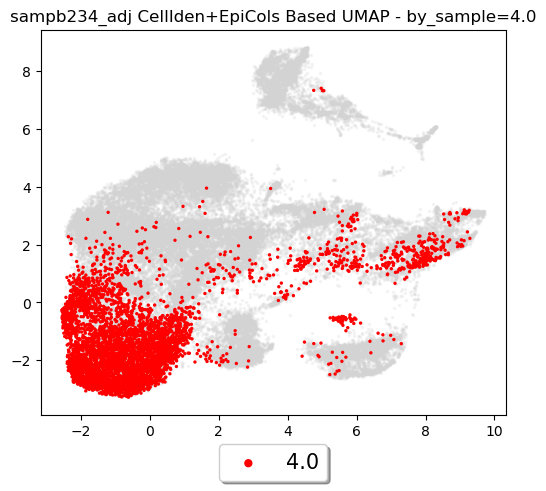

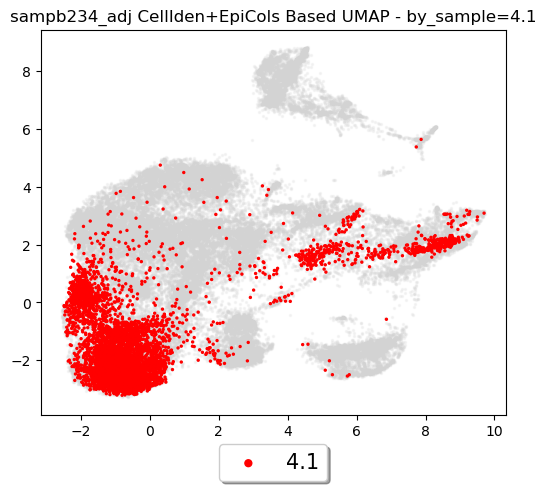

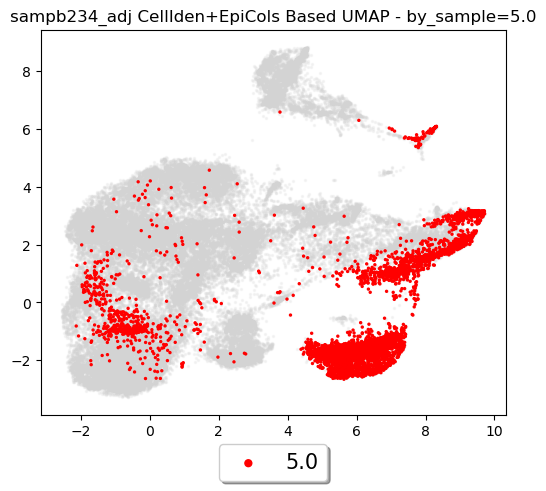

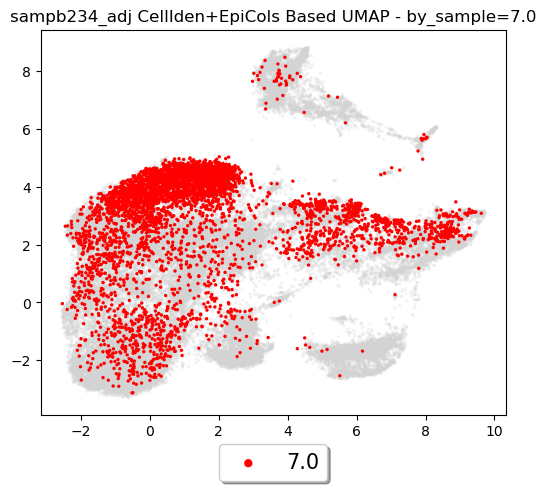

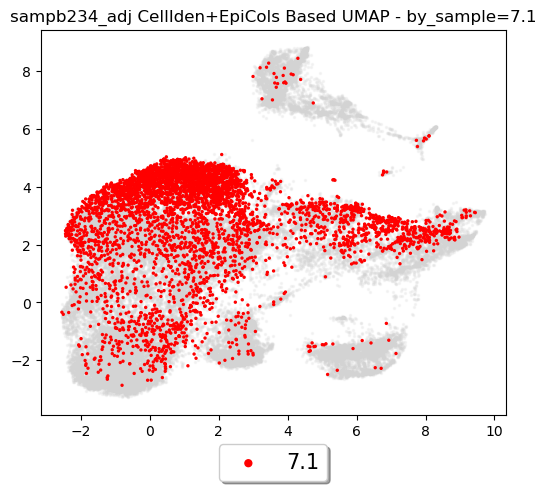

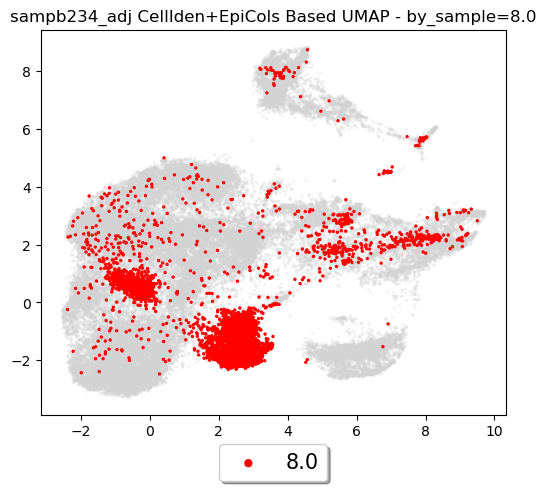

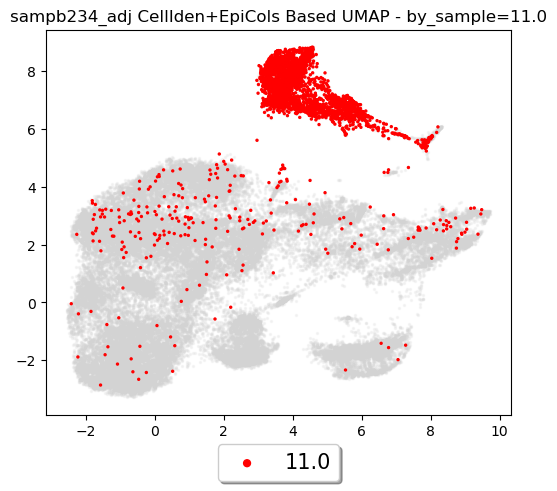

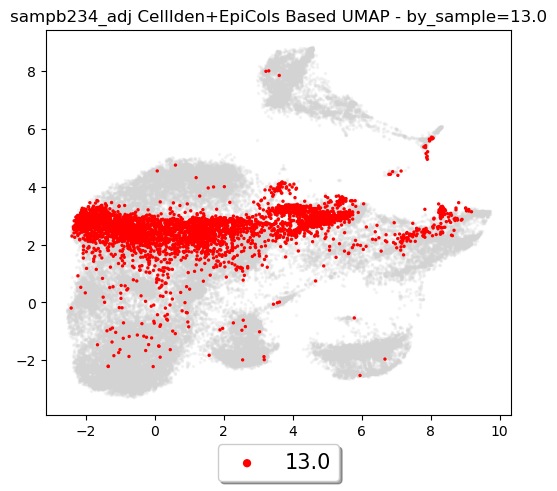

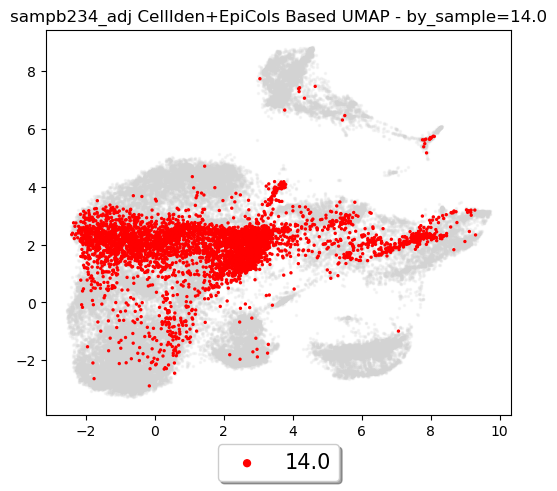

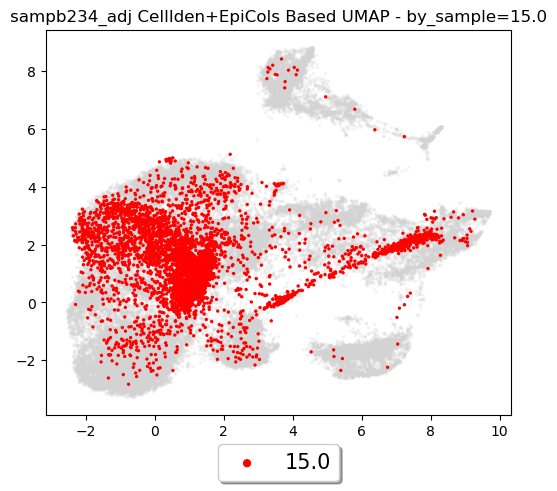

sampb234_adj_CellIden+EpiCols_: cluster 0 sample 4.0 = 41.26
sampb234_adj_CellIden+EpiCols_: cluster 0 sample 4.1 = 42.76
sampb234_adj_CellIden+EpiCols_: cluster 0 sample 5.0 = 3.83
sampb234_adj_CellIden+EpiCols_: cluster 0 sample 7.0 = 4.27
sampb234_adj_CellIden+EpiCols_: cluster 0 sample 7.1 = 3.07
sampb234_adj_CellIden+EpiCols_: cluster 0 sample 8.0 = 0.61
sampb234_adj_CellIden+EpiCols_: cluster 0 sample 11.0 = 0.2
sampb234_adj_CellIden+EpiCols_: cluster 0 sample 13.0 = 0.47
sampb234_adj_CellIden+EpiCols_: cluster 0 sample 14.0 = 1.43
sampb234_adj_CellIden+EpiCols_: cluster 0 sample 15.0 = 2.1
sampb234_adj_CellIden+EpiCols_: cluster 1 sample 4.0 = 1.1
sampb234_adj_CellIden+EpiCols_: cluster 1 sample 4.1 = 0.79
sampb234_adj_CellIden+EpiCols_: cluster 1 sample 5.0 = 0.39
sampb234_adj_CellIden+EpiCols_: cluster 1 sample 7.0 = 7.24
sampb234_adj_CellIden+EpiCols_: cluster 1 sample 7.1 = 9.36
sampb234_adj_CellIden+EpiCols_: cluster 1 sample 8.0 = 1.53
sampb234_adj_CellIden+EpiCols_: clust

In [8]:
# from plot_functions import *
if args['visualize'] and not singleSample:
    # unique by_sample values
    for sampNum in np.unique(k['by_sample']):
        ind_samp = [i for i, j in enumerate(k.by_sample == sampNum) if j]
        labels_samp = np.ones(len(ind_samp))*sampNum
        drawUMAPbySample(umapData, k, ind_samp, labels_samp, settings,
                         title=title+f' UMAP - by_sample={sampNum}',
                         Figname='4_'+figname+f'UMAP_sample{sampNum}_by_sample')
    arr = []
    clustNums = np.unique(k.Clust)
    clustNums = clustNums[clustNums != -1]
    for clustNum in clustNums:
        ind = k.Clust == clustNum
        PercentageBySample = ClustPercentageBySample(k[ind], 'by_sample')

        arr.append([clustNum, PercentageBySample])
    saveCsv(dir_plots, figname, arr)


all samples

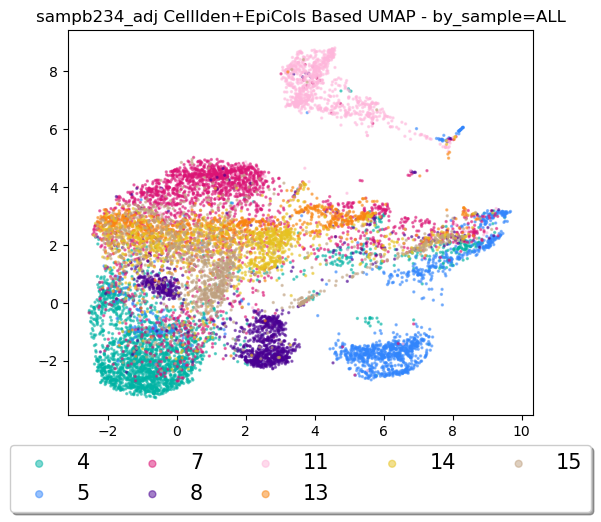

In [15]:
# from plot_functions import *


if args['visualize'] and not singleSample:
    # remove 4.1,7.1 and subsample 
    ind_samp =k.index.values[[ True  if i!='4.1' and i!='7.1' else False for i in k.by_sample]]
    ind_samp=np.random.choice(ind_samp, replace = False, size = int(len(k)/4))
    labels_samp = np.asarray(k.by_sample).astype(int)[ind_samp]

    # ind_samp = k.index.values
    # labels_samp = np.asarray(k.by_sample)[ind_samp]


    colors_samp = np.zeros((np.max(labels_samp)+2,4))
    hex = ['00B3A4','3185FC','DB1374','490092','FEB6DB','F98510','E6C220','BFA180','920000','461A0A']
    colors_samp[1+np.unique(labels_samp)] = np.asarray([hex_to_rgba(h) for h in hex])[:np.unique(labels_samp).shape[0]]
    drawUMAPbySample(umapData, k, ind_samp, labels_samp, settings,colors_samp,backgroundColor = 'white',
                        title=title+f' UMAP - by_sample=ALL',
                        Figname='4_'+figname+f'UMAP_sampleAll_by_sample')
 


by cluster

dbLabels_samp4_CellIden+EpiCols_ ; loaded from file
dbColors_samp4_CellIden+EpiCols_ ; loaded from file


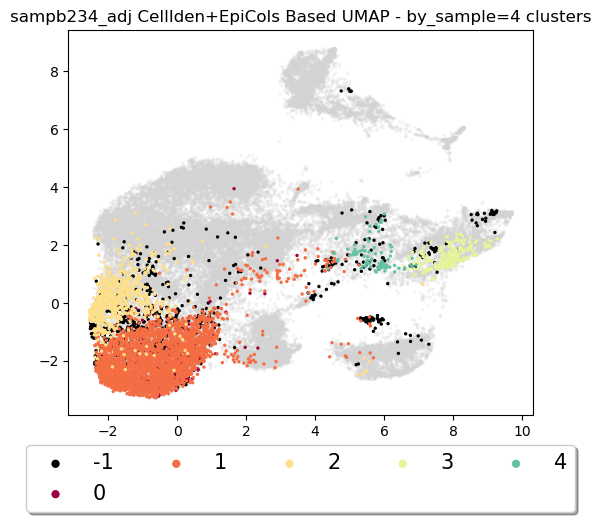

dbLabels_samp4.1_CellIden+EpiCols_ ; loaded from file
dbColors_samp4.1_CellIden+EpiCols_ ; loaded from file


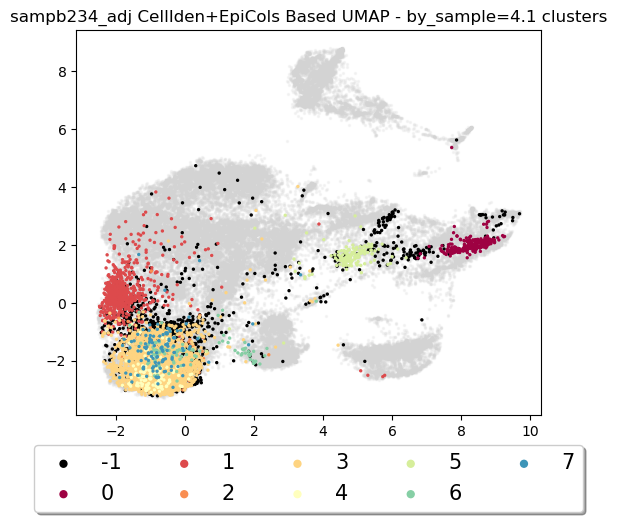

dbLabels_samp5_CellIden+EpiCols_ ; loaded from file
dbColors_samp5_CellIden+EpiCols_ ; loaded from file


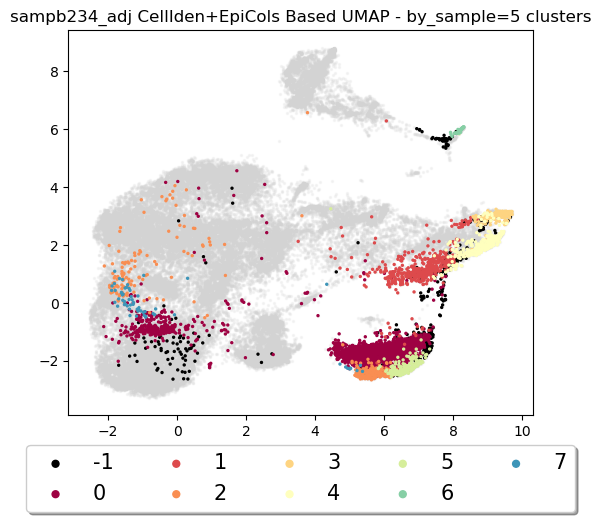

dbLabels_samp7_CellIden+EpiCols_ ; loaded from file
dbColors_samp7_CellIden+EpiCols_ ; loaded from file


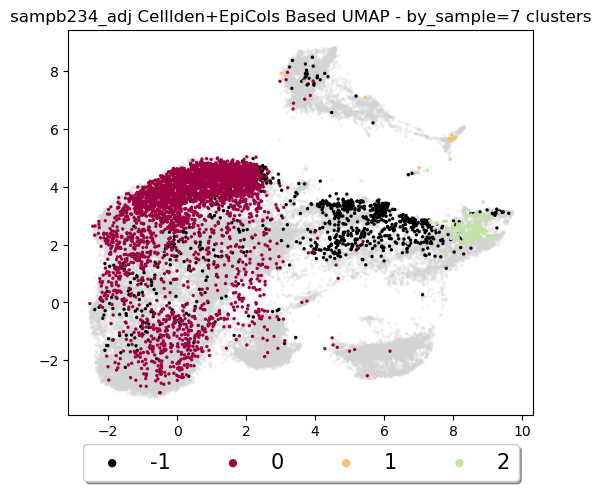

dbLabels_samp7.1_CellIden+EpiCols_ ; loaded from file
dbColors_samp7.1_CellIden+EpiCols_ ; loaded from file


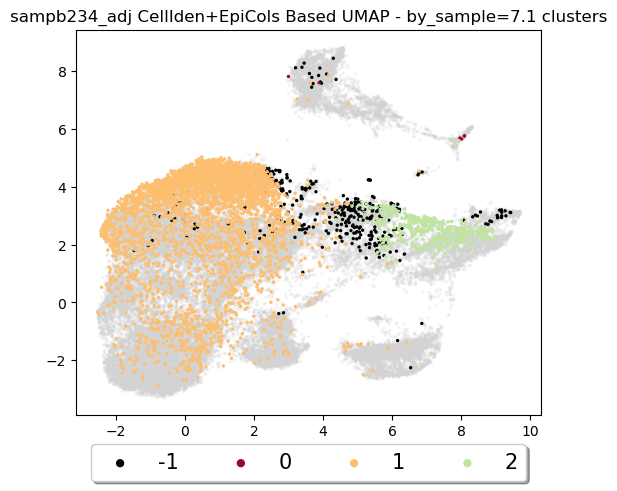

dbLabels_samp8_CellIden+EpiCols_ ; loaded from file
dbColors_samp8_CellIden+EpiCols_ ; loaded from file


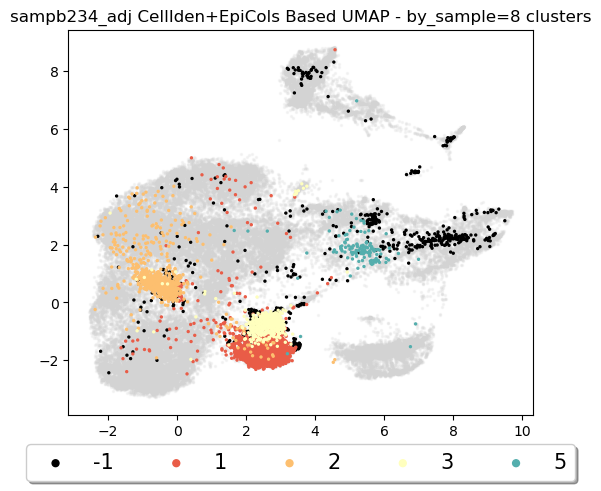

dbLabels_samp11_CellIden+EpiCols_ ; loaded from file
dbColors_samp11_CellIden+EpiCols_ ; loaded from file


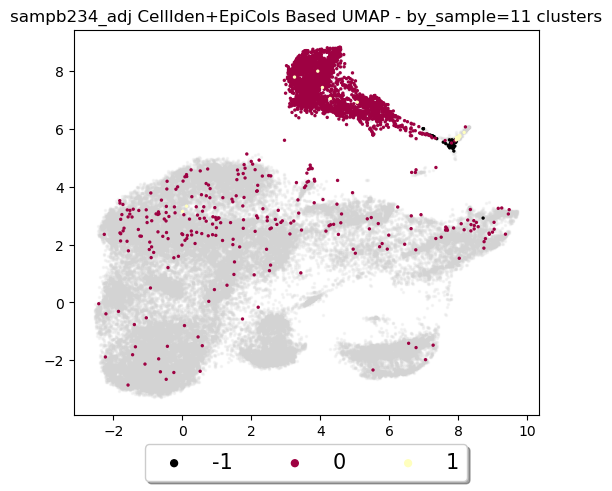

dbLabels_samp13_CellIden+EpiCols_ ; loaded from file
dbColors_samp13_CellIden+EpiCols_ ; loaded from file


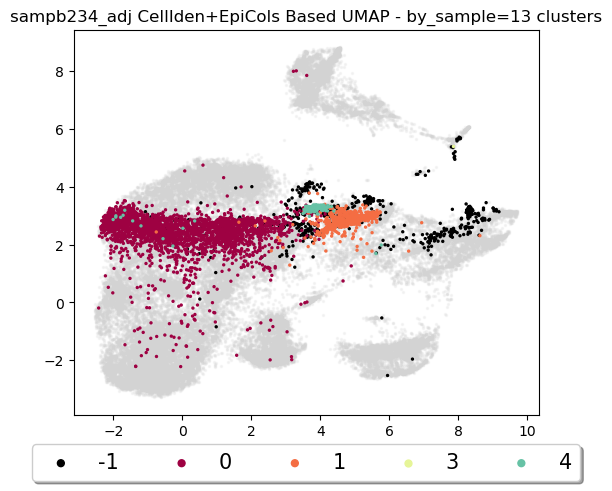

dbLabels_samp14_CellIden+EpiCols_ ; loaded from file
dbColors_samp14_CellIden+EpiCols_ ; loaded from file


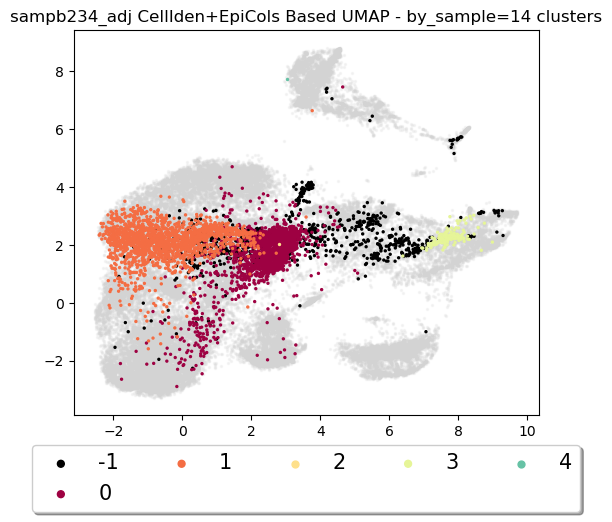

dbLabels_samp15_CellIden+EpiCols_ ; loaded from file
dbColors_samp15_CellIden+EpiCols_ ; loaded from file


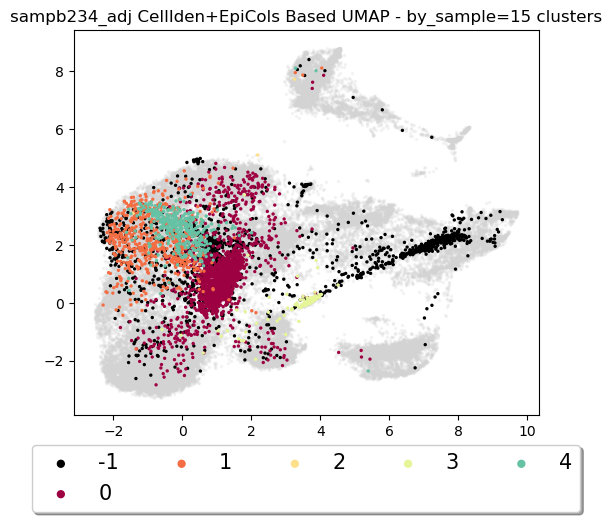

In [16]:
from plot_functions import *
if args['visualize'] and not singleSample:
    # plt.scatter(umapData[:,0],umapData[:,1],c = 'lightgrey', alpha=0.2,s=2)
    uniq = [int(i) if (np.round(i,1) - np.round(i,0)==0) else float(i)  for i in np.unique(k['by_sample'])]
    # print(uniq)
    # unique by_sample values
    for sampNum in uniq:
        # sampNum = uniq[-1]

        # ind_umap = [i for i, j in enumerate(k.by_sample == sampNum) if j]
        # labels_samp = np.asarray(pickle_load(f'dbLabels_samp{sampNum}_{name}_', dir_data))
        
        # sample indexs which are the full dataset - filter db labels by it
        ind_samp = [i for i, j in zip(k.Ind,k.by_sample == sampNum) if j]
        # corresponding indexes in the full data set - where each point in the full umap
        ind_umap = [i for i, j in zip(k.index,k.by_sample == sampNum) if j]        
        labels_samp = np.asarray(pickle_load(f'dbLabels_samp{sampNum}_{name}_', dir_data))[ind_samp]
        # colors_samp = pickle_load(f'dbColors_samp{sampNum}_{name}_', dir_data)
        colors_samp = np.vstack(([0,0,0,1],np.asarray(pickle_load(f'dbColors_samp{sampNum}_{name}_', dir_data))))
        # pickle_dump(f'dbColors_{figname}', colors, dir_data)

        drawUMAPbySample(umapData, k, ind_umap, labels_samp, settings,colors_samp,
                         title=title+f' UMAP - by_sample={sampNum} clusters',
                         Figname='4_'+figname+f'UMAP_sample{sampNum}_by_sample_clusters')
        
# [4, 4.1, 5, 7, 7.1, 8, 11, 13, 14, 15]


## features on UMAP


shap

In [16]:
if args['visualize'] and args['plotUMAP']:
    ind = labels !=-1 # drop unclustered rows (clust==-1)
    accuracy = xg_classification_shap(CAll[featureGroup].copy(),labels.copy(),ind,colors,
                                    settings,figname='5_'+figname+'shap')
    print(f"accuracy {j}_{group_ind}: {accuracy}%")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


accuracy b234_adj_2: 94.19999999999999%


plot Clusters

In [17]:
if args['visualize'] and args['plotUMAP']:
    plotClusters(k, umapData, labels, colors, NamesAll, settings,
                title='Clusters ' + title,
                figname='1_'+figname+'Clusters')

X converted to numpy array with dtype object
Transforming to str index.
No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


plot features on umap 

In [18]:
if args['visualize'] and args['plotUMAP']:
    drawUMAP(umapData, NamesAll, CAll, settings,
             title='UMAP ' + title,
             Figname='2_'+figname+'UMAP_')


## scatter figures


In [19]:
# if args['visualize']:
#     try:
#         scatter(k, 'NCad', 'ECad', title, figname, settings)
#     except:
#         print('no ncad in sample')


## clear data


In [20]:
# dbscanData, umapData,k, CAll,labels = None,None,None,None,None
# imList2pdf(dir_plots,j,['CellIden','EpiCols','CellIden+EpiCols'])
